# ⛈️ ⛈️ Equal-Filling Degree Control of pystorms Scenario gamma ⛈️ ⛈️

In [ ]:
# Google Colab might need to reinstall pystorms
!pip install pystorms

In [1]:
import pystorms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# RC parms for pretty plots
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-dark-palette')

In this example, we are using scenario gamma

![gamma](./gamma_sheet.png)

### Model IDs in Scenario gamma
```yaml
# name of scenario 
name: gamma
# state definitions
states:
        - !!python/tuple 
          - "1"
          - depthN
          # ... through "11" depthN
# Action space 
action_space:
        - O1
        # ... through O11
# Performance Targets
performance_targets:
        - !!python/tuple
          - O1
          - flow
          # ... through O11 flow
          - !!python/tuple
          - "1"
          - flooding
          # ... through "11" flooding
          - !!python/tuple 
          - "1"
          - depthN
          # ... through "11" depthN
```

### Uncontrolled performance of Scenario gamma
In the uncontrolled case, all control assets are open (i.e., set to 1).

In [10]:
env = pystorms.scenarios.gamma()
done = False

while not done:
    # Query the current state of the simulation
    state = env.state()
    
    # Initialize actions to have each asset open
    actions = np.ones(11)
    
    # Set the actions and progress the simulation
    done = env.step(actions)
    
# Calculate the performance measure for the uncontrolled simulation
uncontrolled_perf = sum(env.data_log["performance_measure"])

In [11]:
print("The calculated performance for the uncontrolled case of Scenario gamma is:")
print("{}.".format(uncontrolled_perf))

The calculated performance for the uncontrolled case of Scenario gamma is:
400221923.1345468.


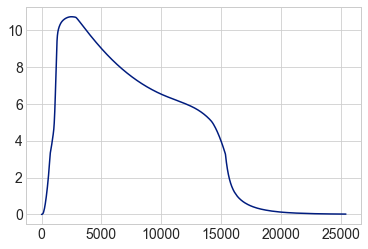

In [13]:
plt.plot(env.data_log['flow']['O1'])
#plt.plot(env.data_log['depthN']['2'])
#plt.plot(env.data_log['depthN']['3'])
#plt.plot(env.data_log['depthN']['4'])

### Equal-Filling Degree Control of Scenario gamma
We will now set up an equal-filling degree approach to control Scenario gamma.

Instead of controlling the valves at the outlets of all 11 basins in the network, we will focus on controlling only the most downstream 4 basins, namely storage units 1, 2, 3, 4 with valves O1, O2, O3, O4.

INCLUDE OVERVIEW OF EFD IDEA

The function defined below builds the logic of the equal-filling degree approach. It is given the current relevant states and settings. In this case, the states are the depths of the 4 basins we are controlling, and the settings are for their respective outlet valves.

In [152]:
def controller_efd(state):
    # Initialize the action space so that we can compute the new settings
    new_settings = np.ones(4)
    # Set equal-filling degree parameters
    c = 0.8
    theta = 0.25
    
    # Specify the maximum depth of each basin
    max_depths = [5., 10., 10., 10.]
    # Assign the current depth in each basin
    depths = state
    
    # Compute the filling degrees
    fd = depths/max_depths
    # Compute the average filling degree
    fd_average = sum(fd)/len(fd)
    
    for i in range(0,len(fd)):
        if fd[i] > fd_average:
            new_settings[i] = c*(fd[i]-fd_average)
        elif fd_average-fd[i] <= theta:
            new_settings[i] = fd_average
        else:
            new_settings[i] = 0.
        new_settings[i] = min(new_settings[i], 1.)
        new_settings[i] = max(new_settings[i], 0.)

    return new_settings

Now we will use the above equal-filling degree function to run the simulation and make the control decisions as prescribed.

In [153]:
env = pystorms.scenarios.gamma()
done = False

while not done:
    # Query the current state of the simulation
    state = env.state()
    states_relevant = state[0:4]
    
    # Initialize actions to have each asset open
    actions_efd = controller_efd(states_relevant)
    actions_uncontrolled_5_11 = np.ones(7)
    actions = np.concatenate((actions_efd, actions_uncontrolled_5_11), axis=0)
    
    # Set the actions and progress the simulation
    done = env.step(actions)
    
# Calculate the performance measure for the uncontrolled simulation
equalfilling_perf = sum(env.data_log["performance_measure"])

In [154]:
print("The calculated performance for the equal filling degree case of Scenario gamma is:")
print("{}.".format(equalfilling_perf))

The calculated performance for the equal filling degree case of Scenario gamma is:
402895896.4199196.


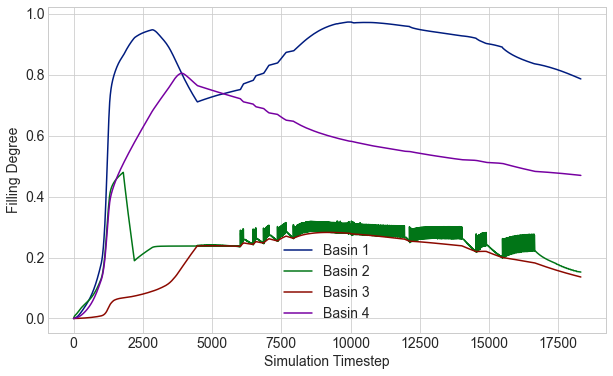

In [157]:
max_depths = [5., 10., 10., 10.]

plt.figure(figsize=(10,6))
plt.plot(np.asarray(env.data_log['depthN']['1'])/max_depths[0], label='Basin 1')
plt.plot(np.asarray(env.data_log['depthN']['2'])/max_depths[1], label='Basin 2')
plt.plot(np.asarray(env.data_log['depthN']['3'])/max_depths[2], label='Basin 3')
plt.plot(np.asarray(env.data_log['depthN']['4'])/max_depths[3], label='Basin 4')
plt.xlabel('Simulation Timestep')
plt.ylabel('Filling Degree')
plt.legend()

Text(0, 0.5, 'Flow')

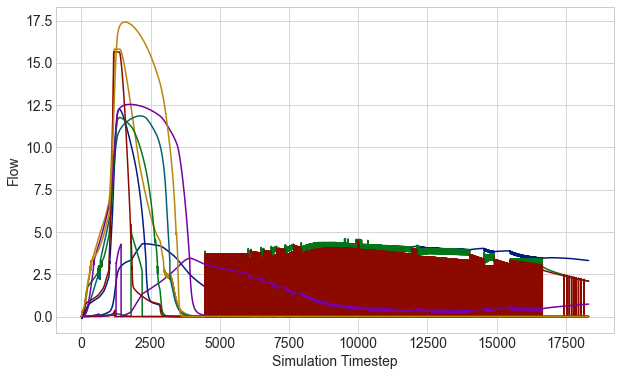

In [159]:
plt.figure(figsize=(10,6))
plt.plot(env.data_log['flow']['O1'])
plt.plot(env.data_log['flow']['O2'])
plt.plot(env.data_log['flow']['O3'])
plt.plot(env.data_log['flow']['O4'])
plt.plot(env.data_log['flow']['O5'])
plt.plot(env.data_log['flow']['O6'])
plt.plot(env.data_log['flow']['O7'])
plt.plot(env.data_log['flow']['O8'])
plt.plot(env.data_log['flow']['O9'])
plt.plot(env.data_log['flow']['O10'])
plt.plot(env.data_log['flow']['O11'])
plt.xlabel('Simulation Timestep')
plt.ylabel('Flow')